### 3. Generación de Lenguaje Natural
Implementación de un modelo de generación de lenguaje utilizando algún dataset de los propuestos de Twitter.

El objetivo es el de simular la creación de un bot que escriba tweets de manera similar al del autor utilizado para el entrenamiento.

Se valorará principalmente la argumentación de los pasos realizados y las conclusiones al analizar los resultados y limitaciones encontradas.

Esta práctica se ha realizado en colab por lo que hay algunas celdas que no funcionaran el jupyeter o algunas rutas que no se corresponden una estructura de un sistema normal


In [1]:
# Importamos a lo que vayamos a necesitar

import numpy as np
import pandas as pd
import re
import random
from copy import deepcopy
import matplotlib.pyplot as plt
from matplotlib import cm

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
#  connectamos con drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Cargamos los datos

In [3]:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/NLP/NeildeGrasseTysonTweets.csv')

In [4]:
data.head()

,Unnamed: 0,date,id,link,retweet,text,author
0,0,Aug 21,767371694834978816,/neiltyson/status/767371694834978817,False,"Moon’s shadow landfalls Oregon, crosses USA at...",deGrasseTyson
1,1,Oct 9,785186636946636800,/neiltyson/status/785186636946636800,False,"@huggy_panda Oink, oink. : - )",deGrasseTyson
2,2,Oct 9,785131023923314688,/neiltyson/status/785131023923314688,False,"Future headlines from the Multiverse: Nov 9, 2...",deGrasseTyson
3,3,Oct 7,784443331568930816,/neiltyson/status/784443331568930817,False,Awww. That’s the nicest thing anybody has said...,deGrasseTyson
4,4,Oct 6,784089429120020480,/neiltyson/status/784089429120020481,False,"If ComicCon people ruled the world, internatio...",deGrasseTyson


In [5]:
data = data[['retweet', 'text', 'author']]

In [6]:
data.head()

,retweet,text,author
0,False,"Moon’s shadow landfalls Oregon, crosses USA at...",deGrasseTyson
1,False,"@huggy_panda Oink, oink. : - )",deGrasseTyson
2,False,"Future headlines from the Multiverse: Nov 9, 2...",deGrasseTyson
3,False,Awww. That’s the nicest thing anybody has said...,deGrasseTyson
4,False,"If ComicCon people ruled the world, internatio...",deGrasseTyson


### Preprocesado

In [7]:
# Definimos unas regex que emplearemos para eliminar los siguientes campos:
#  - Usuarios/Menciones
#  - Hashtag
#  - Urls
#  - Imagenes

user_regex = re.compile('@\w+| @\w+ ')
hashtag_regex = re.compile('#\w+| #\w+ ')
url_regex = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
pics_regex = re.compile('pic?.\w+.\w+\/\w+')

In [8]:
users = []
hashtags = []
urls = []
pics = []


texts = []
for text in data['text']:
    
    users.extend([it.strip()for it in user_regex.findall(text)])
    hashtags.extend([it.strip()for it in hashtag_regex.findall(text)])
    urls.extend([it.strip()for it in url_regex.findall(text)])
    pics.extend([it.strip()for it in pics_regex.findall(text)])
    
    aux = text
    aux = re.sub(pics_regex, ' ', aux)
    aux = re.sub(url_regex, ' ', aux) 
    aux = re.sub(user_regex.pattern, ' ', aux)
    aux = re.sub(hashtag_regex.pattern, ' ', aux)

    # aux = re.sub('¢|ä|é|ö|ú|ī|–|‘|’|“|”|=|<|>', '', aux)
    
    aux = aux.strip()

    texts.append(aux)

In [9]:
# Vemos como se ha quedado nuestro texto procesado
len(texts)

2428

In [10]:
# Combinamos los textos en una unica lista
text = r' '.join(texts)

In [11]:
#  Sacamos los caracteres que componen nuestro corpus
characters = sorted(list(set(text)))
n_to_char = {n:char for n, char in enumerate(characters)}
char_to_n = {char:n for n, char in enumerate(characters)}

print('Unique chars: {}'.format(len(characters)))

Unique chars: 104


In [12]:
print(characters)

['\n', ' ', '!', '"', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '\xa0', '¢', 'ä', 'é', 'ö', 'ú', 'ī', '–', '—', '‘', '’', '“', '”', '…', '⁰']


###'Traducimos' nuestros datos a numero

In [13]:
# Definimos las constantes
window = 8

text = ' '.join(texts)

In [14]:
def text_conversion(text, ctn_dict, window=5, step=1):

    l = len(text) - window

    X = np.ndarray(shape=(l, window), dtype=int)
    
    Y = np.zeros(l, dtype=int)
    
    for i in range(0, l, step):
        sequence = text[i: i + window]
        label = text[i + window]
        
        X[i] =  np.asarray([ctn_dict[c] for c in sequence])
        Y[i] = ctn_dict[label]
        
    return X,Y

In [15]:
X, Y = text_conversion(text, char_to_n, window=window)

In [16]:
X[0]

array([44, 77, 77, 76, 99, 81,  1, 81])

In [17]:
X_modified = np.reshape(X, (len(X), window, 1))
X_modified = X_modified / float(len(characters))
Y_modified = np_utils.to_categorical(Y)

In [18]:
Y_modified.shape

(263472, 104)

### Comenzamos con nuestro modelo

In [19]:
def plot_values(title, values, marker=None, plt=plt):
  cmap = cm.get_cmap('tab10', len(values))
  for i, (tit, vals) in enumerate(values):
    if marker:
      plt.plot(np.arange(0, len(vals)), vals, marker, color=cmap(i), label=tit)
    else: 
      plt.plot(np.arange(0, len(vals)), vals, color=cmap(i), label=tit)

  if hasattr(plt, 'xlabel'):
    plt.xlabel('Values #')
  else:
    plt.set_xlabel("Values #")

  if hasattr(plt, 'ylabel'):
    plt.ylabel(f"{title}")
  else:
    plt.set_ylabel(f"{title}")
  plt.legend()

In [20]:
def create_nlp_network(shape, otputs):

  model = Sequential()

  model.add(LSTM(700, input_shape=shape, return_sequences=True))
  model.add(Dropout(0.2))
  
  model.add(LSTM(700))
  model.add(Dropout(0.2))

  model.add(Dense(Y_modified.shape[1], activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer='adam')

  return model


In [21]:
model = create_nlp_network(X_modified.shape[1:], Y_modified.shape[1])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 8, 700)            1965600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 700)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 700)               3922800   
_________________________________________________________________
dropout_2 (Dropout)          (None, 700)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 104)               72904     
Total params: 5,961,304
Trainable params: 5,961,304
Non-trainable params: 0
_________________________________________________________________


In [22]:
history = model.fit(
    X_modified, Y_modified, 
    validation_split=0.05, 
    batch_size=128, 
    epochs=25).history

Train on 250298 samples, validate on 13174 samples
Epoch 1/25
250298/250298 [==============================] - 164s 653us/step - loss: 3.0442 - val_loss: 2.9438
Epoch 2/25
250298/250298 [==============================] - 164s 655us/step - loss: 2.8603 - val_loss: 2.8402
Epoch 3/25
250298/250298 [==============================] - 165s 657us/step - loss: 2.7630 - val_loss: 2.7505
Epoch 4/25
250298/250298 [==============================] - 166s 662us/step - loss: 2.6644 - val_loss: 2.6678
Epoch 5/25
250298/250298 [==============================] - 167s 667us/step - loss: 2.5656 - val_loss: 2.6000
Epoch 6/25
250298/250298 [==============================] - 169s 676us/step - loss: 2.4731 - val_loss: 2.5387
Epoch 7/25
250298/250298 [==============================] - 165s 660us/step - loss: 2.3805 - val_loss: 2.5068
Epoch 8/25
250298/250298 [==============================] - 167s 666us/step - loss: 2.2989 - val_loss: 2.4546
Epoch 9/25
250298/250298 [==============================] - 165s 660u

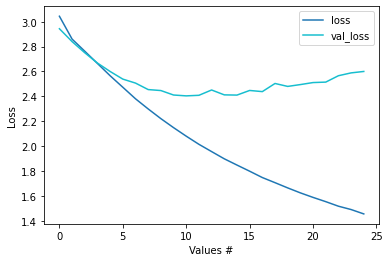

In [24]:
plot_values('Loss', [('loss', history['loss']), ('val_loss', history['val_loss'])])

In [25]:
def generate_text(model, initial_sequence):
    string_mapped = deepcopy(initial_sequence.tolist())
    full_string = [n_to_char[value] for value in string_mapped]
    
    # Generating characters
    # Generamos un tweet entre  280(el maximo actual de tweeter)
    characters_length = random.randint(len(string_mapped)+10, 280 )
    for i in range(characters_length):
        x = np.reshape(string_mapped,(1,len(string_mapped), 1))
        x = x / float(len(characters))

        pred_index = np.argmax(model.predict(x, verbose=0))
        seq = [n_to_char[value] for value in string_mapped]
        full_string.append(n_to_char[pred_index])

        string_mapped.append(pred_index)
        string_mapped = string_mapped[1:len(string_mapped)]
        
    text = ""
    for char in full_string:
        text = text + char
    return text

In [28]:
generate_text(model, X[0])

'Moon’s shme a pianet ou soop on the Sun will dxplouers to the Sun will dxplouers to'

In [241]:
# Ahora exportaremos nuestro modelo para poder reutilizarlo posteriormente
def export_modoel(model, name):
  model.save(f"{name}.h5")
  
  !cp {name}.h5 /content/drive/My\ Drive/Colab\ Notebooks/NLP/{name}.h5

  print("Saved model to disk")

In [44]:
export_modoel(model, 'nlg_2')

Saved model to disk


Como conclusiones de esta practica llego a que después de probar varios modelos depende mucho de el numero de epocas y del preprocesado que hagas obener un texto 'natral', basicamente mi proceso sobre esta pŕactica ha sido el de copiar una estructura básica e iterar sobre ella añadirndo etapas en la limpieza y cambiando los parametros del entrenamiento 'batch_size' y 'epochs'.

El reusltado final se ve que no es muy 'optimo' pero ha sido mucho tiempo y varias pruebas para intetar crar un mdelo que genre lenguaje 'natual'